In [1]:
import dadrah.analysis.root_plotting_util as rpu
import dadrah.util.run_paths as runpa
import dadrah.util.string_constants as stco
import pofah.jet_sample as js
import pofah.phase_space.cut_constants as cuts

import pathlib
import argparse
from typing import List

import numpy as np
import ROOT as rt
import root_numpy as rtnp
import uuid
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import root_numpy as rtnp
import mplhep as hep
plt.style.use(hep.style.ROOT)
from typing import List

Welcome to JupyROOT 6.18/04


## run config

In [2]:
ae_run_n = 113
#qr_run_n, qr_model_str, sample_id_qcd, tag = 4, 'poly', 'qcdSigAllTestReco', 'PDinj_NA3p5'
qr_run_n, qr_model_str, sample_id_qcd, tag, train_frac = 7, 'dense_polyfit_envelope', 'qcdSigAllTest80pct', 'PDinj_NA3p5_r7env', 0.2
#qr_run_n, qr_model_str, sample_id_qcd, tag, train_frac = 8, 'dense_70pct_train', 'qcdSigAllTest30pct', 'PDinj_NA3p5_r8', 0.7
#qr_run_n, qr_model_str, sample_id_qcd, tag, train_frac = 9, 'dense_50pct_train', 'qcdSigAllTest50pct', 'PDinj_NA3p5_r9', 0.5
qr_run_n, qr_model_str, sample_id_qcd, tag, train_frac = 31, 'dense_kfold', 'qcdSigAll', 'PDinj_NA3p5_r7env', 0

xsec_train = 0 # signal cross section used when training the QR
xsecs_sig   = [0,20,40,60,80,100] # signal cross sections
mX = 3.5

sample_ids = [sample_id_qcd, 'GtoWW35naReco']
sample_id_sig = sample_ids[1]
#quantiles = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
quantiles = [0.3, 0.5, 0.7, 0.9]
#quantiles = [0.3, 0.5, 0.7, 0.9]

# choose which template quantile to use (0 = 0.9-1.0, 1 = 0.7-0.9)
template_q_idx = 0
# Set binning
dijet_bin = True
poly_cut = False

In [3]:
# Rescaling the inputs to lumi
xsec_qcd       = 8730000.0 # Crossection in fb             
qcd_gen_events = 134366091.0+199435365.0+90490645.0+134264102.0 #(all generated QCD)
xsec_sig_default = 10. #In units of fb (10 fb == 0.01 pb) 
sig_gen_events = 982038.0 #(all generated signal)
lumi           = qcd_gen_events/xsec_qcd # assuming 64/fb since qcd_gen_events/8730000 ~ 64

scale_qcd = xsec_qcd*lumi/qcd_gen_events
scale_sig = (1-train_frac)*xsec_sig_default*lumi/sig_gen_events #20% already used for quantile regression, must be removed
print('Usign luminosity {}'.format(lumi))
print('Scale {} QCD events with {}'.format(qcd_gen_events,scale_qcd))
print('Scale {} signal events with {} for 10fb default sig xsec'.format(sig_gen_events,scale_sig))

Usign luminosity 63.98123745704467
Scale 558556203.0 QCD events with 1.0
Scale 982038.0 signal events with 0.0001303029769867249 for 10fb default sig xsec


# read in data

### train xsec = 0 !

In [4]:
if poly_cut:
    paths = runpa.RunPaths(in_data_dir=stco.dir_path_dict['base_dir_qr_selections_poly_cut'], in_data_names=stco.file_name_path_dict, out_data_dir=stco.dir_path_dict['base_dir_qr_analysis'])
    path_ext_dict = {'vae_run': str(ae_run_n), 'qr_run': str(qr_run_n), 'sig': sample_id_sig[:-4], 'xsec': str(int(xsec_train)), 'loss': 'rk5_05', 'order':'5'}
else:
    paths = runpa.RunPaths(in_data_dir=stco.dir_path_dict['base_dir_qr_selections'], in_data_names=stco.file_name_path_dict, out_data_dir=stco.dir_path_dict['base_dir_qr_analysis'])
    path_ext_dict = {'vae_run': str(ae_run_n), 'qr_run': str(qr_run_n), 'sig': sample_id_sig, 'xsec': str(int(xsec_train)), 'loss': 'rk5_05'}

paths.extend_in_path_data(path_ext_dict)
paths.extend_out_path_data({**path_ext_dict, 'mjj_spectra': None, 'orthogonal': None})

samples = {}

for sample_id in sample_ids:
    samples[sample_id] = js.JetSample.from_input_file(sample_id, paths.in_file_path(sample_id), **cuts.signalregion_cuts)

### divide into orthogonal quantiles

In [5]:
def divide_sample_into_orthogonal_quantiles(sample:js.JetSample, quantiles:List) -> List[js.JetSample]:

    quantiles_inv = [round((1.-q),2) for q in quantiles] # invert quantiles to [0.9, 0.7, 0.5, 0.3, 0.1, 0.01]

    samples_ortho = []

    # process bottom quantile (didn't make first cut, e.g. sel 0.9 == 0)
    q_key = 'sel_q{:02}'.format(int(quantiles_inv[0]*100))
    samples_ortho.append(sample.filter(~sample[q_key]))

    # process all quantiles except for last (tightest)
    for q_i, q_ii in zip(quantiles_inv[:-1], quantiles_inv[1:]):

        q_i_key, q_ii_key = 'sel_q{:02}'.format(int(q_i*100)), 'sel_q{:02}'.format(int(q_ii*100))

        sample_q_next = sample.filter(sample[q_i_key] & ~sample[q_ii_key])
        samples_ortho.append(sample_q_next)

    # process tightest quantile
    q_key = 'sel_q{:02}'.format(int(quantiles_inv[-1]*100))
    samples_ortho.append(sample.filter(sample[q_key]))

    return samples_ortho

In [6]:
# qcd
samples_ortho_quantiles_qcd = divide_sample_into_orthogonal_quantiles(samples[sample_id_qcd], quantiles)
mjj_vals_qcd = [sample_ortho['mJJ'] for sample_ortho in samples_ortho_quantiles_qcd]
# signal
samples_ortho_quantiles_sig = divide_sample_into_orthogonal_quantiles(samples[sample_id_sig], quantiles)
mjj_vals_sig = [sample_ortho['mJJ'] for sample_ortho in samples_ortho_quantiles_sig]

In [7]:
num_samples_qcd = sum(map(len,mjj_vals_qcd))
print(num_samples_qcd)
num_samples_sig = sum(map(len,mjj_vals_sig))
print(num_samples_sig)

7671759
531825


In [8]:
quantiles_inv = [round((1.-q),2) for q in [0]+quantiles] # invert quantiles to [1.0 0.9, 0.7, 0.5, 0.3, 0.1, 0.01]
q_str_leg = [str(q) for q in quantiles_inv+[0.]]

In [9]:
q_str_leg

['1.0', '0.7', '0.5', '0.3', '0.1', '0.0']

In [10]:
# Dijet variable-binwidth binning (depends on dijet resolution)
if dijet_bin:
    bin_edges = np.array([1200, 1255, 1320, 1387, 1457, 1529,
                          1604, 1681, 1761, 1844, 1930, 2019, 
                          2111, 2206, 2305, 2406, 2512, 2620, 
                          2733, 2849, 2969, 3093, 3221, 3353,
                          3490, 3632, 3778, 3928, 4084, 4245, 
                          4411, 4583, 4760, 4943, 5132, 5327]).astype('float')
                          #5574, 5737, 5951, 6173, 6402, 6638, 6882]).astype('float')
# Constant binwidth
else:
    bin_edges = np.array(np.arange(1200.,6800., 50.).tolist()).astype('float') #100 GeV binning. Stop at 5600! Fit fails if going to 6800


n_bins = len(bin_edges)-1
max_bin = bin_edges[-1]
min_bin = bin_edges[0]

In [11]:
n_bins

35

### color palettes

In [12]:
cmap_qcd = cm.get_cmap('winter') # 'summer'
cmap_qcd = [mpl.colors.rgb2hex(c) for c in cmap_qcd(np.linspace(0.0, 1.0, len(mjj_vals_qcd)+1))][1:]
cmap_sig = cm.get_cmap('winter')
cmap_sig = [mpl.colors.rgb2hex(c) for c in cmap_sig(np.linspace(0.0, 1.0, len(mjj_vals_sig)+1))][1:]
bump_col = '#e25650' # colors for signal bump

## fill events into histograms

In [13]:
n_bins = len(bin_edges)-1 #50
hist_sz = 700
marker_sty = 8
marker_sz = 0.85

In [14]:
datas_qcd = {}
datas_sig = {}

# qcd template / bottom histogram
props={'LineColor': rt.kBlack, "YTitle": 'num events', "XTitle": "M_{jj} [GeV]", "Title":"", "Minimum": 0.2, "Maximum": num_samples_qcd*1.1}
datas_qcd[quantiles_inv[template_q_idx]] = rpu.create_hist(mjj_vals_qcd[template_q_idx],'',n_bins, bin_edges.astype('float'), props=props)

# qcd other ortho quantile hists
for mjj, q, c in zip(mjj_vals_qcd[template_q_idx+1:], quantiles_inv[template_q_idx+1:], cmap_qcd[template_q_idx:]):
    props = {"LineColor": rt.TColor.GetColor(c), "MarkerColor": rt.TColor.GetColor(c), "LineWidth": 1, "MarkerStyle": marker_sty, "MarkerSize": marker_sz}
    datas_qcd[q] = rpu.create_hist(mjj, '', n_bins, bin_edges.astype('float'), props=props)

# signal orthogonal quantiles
for mjj, q, in zip(mjj_vals_sig[template_q_idx:], quantiles_inv[template_q_idx:]):
    props = {"LineColor": rt.TColor.GetColor(bump_col), "LineColorAlpha": ((rt.TColor.GetColor(bump_col)), q), "FillColorAlpha": ((rt.TColor.GetColor(bump_col)), q*0.8), "LineWidth": 1,}
    datas_sig[q] = rpu.create_hist(mjj, '', n_bins, bin_edges.astype('float'), props=props)

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


## make histograms with injected signal pseudo data

In [15]:
# this is all for training signal xsec = 0

histos_data_inj = {}
histos_sig_inj = {}

# for each quantile
for q in quantiles_inv[template_q_idx:]:

    q_str = 'q'+str(int(q*100))
    # treat special case when bottom q is bounded on the left: in gof name is hardcoded to q100, so change the name
    if template_q_idx == 1 and q == 0.9: q_str = 'q'+str(100)

    histos_data_inj_quantile = {}
    histos_sig_inj_quantile = {}
    
    # for each signal cross section (each signal injection value)
    for xsec in xsecs_sig:
        
        sig_inj = int(xsec/10)
        print('xsec {}, sig_inj {}'.format(xsec, sig_inj))
        hist_data_xsec = datas_qcd[q].Clone('data_hist_acc_inj{}_{}'.format(sig_inj,q_str)) # get qcd events for quantile q
        hist_sig_xsec = datas_sig[q].Clone('signal_inj{}_{}'.format(sig_inj,q_str)) # get signal events for quantile q
        tmpSig = hist_sig_xsec.Clone('tmp_signal_inj{}_{}'.format(sig_inj,q_str))
        print("Data before injection = {}".format(hist_data_xsec.Integral()))
        
        # Scale signal by the crossection injected (default is 10 fb)
        print("Signal before scaling = {}".format(tmpSig.Integral()))
        tmpSig.Scale(scale_sig*sig_inj if sig_inj != 0 else scale_sig)
        print("Signal after scaling = {}".format(tmpSig.Integral()))
        
        hist_data_xsec.Sumw2() # Sumw2: tell the histogram class to also store errors.
        tmpSig.Sumw2()
        hist_sig_xsec.Sumw2()
        
        rdm = rt.TRandom3(0)
        for i in range (0,tmpSig.GetNbinsX()):
            n = tmpSig.GetBinContent(i+1)  
            n_rdm = rdm.Poisson(n)
            hist_sig_xsec.SetBinContent(i+1,n_rdm)
            hist_sig_xsec.SetBinError(i+1,n_rdm**0.5)
        print("Signal after pseudodata = {}".format(hist_sig_xsec.Integral()))
    
        # add pseudo signal events to qcd events. 
        if sig_inj != 0:
            hist_data_xsec.Add(hist_sig_xsec)
            
        print("Data after injection = {}".format(hist_data_xsec.Integral()))

        hist_data_xsec.SetBinErrorOption(rt.TH1.kPoisson)
        
        # save mixed data histo and signal histo in quantile dict
        histos_data_inj_quantile[sig_inj] = hist_data_xsec
        histos_sig_inj_quantile[sig_inj] = hist_sig_xsec
        
    # save full xsec set for each quantile
    histos_data_inj[q] = histos_data_inj_quantile
    histos_sig_inj[q] = histos_sig_inj_quantile


xsec 0, sig_inj 0
Data before injection = 2299970.0
Signal before scaling = 70996.0
Signal after scaling = 9.250990154149518
Signal after pseudodata = 3.0
Data after injection = 2299970.0
xsec 20, sig_inj 2
Data before injection = 2299970.0
Signal before scaling = 70996.0
Signal after scaling = 18.501980308299036
Signal after pseudodata = 12.0
Data after injection = 2299982.0
xsec 40, sig_inj 4
Data before injection = 2299970.0
Signal before scaling = 70996.0
Signal after scaling = 37.00396061659807
Signal after pseudodata = 31.0
Data after injection = 2300001.0
xsec 60, sig_inj 6
Data before injection = 2299970.0
Signal before scaling = 70996.0
Signal after scaling = 55.50594092489711
Signal after pseudodata = 67.0
Data after injection = 2300037.0
xsec 80, sig_inj 8
Data before injection = 2299970.0
Signal before scaling = 70996.0
Signal after scaling = 74.00792123319614
Signal after pseudodata = 89.0
Data after injection = 2300059.0
xsec 100, sig_inj 10
Data before injection = 229997

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure al

# plot ratio hist for each quantile with increasing xsec added

In [16]:
template_q = quantiles_inv[template_q_idx]
sig_injs = [int(xsec/10) for xsec in xsecs_sig]
sig_inj = sig_injs[-1]

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: pdf file fig/mjj_ratio_inj_sig_xsec_0_qr_run7.pdf has been created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: pdf file fig/mjj_ratio_inj_sig_xsec_20_qr_run7.pdf has been created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of 

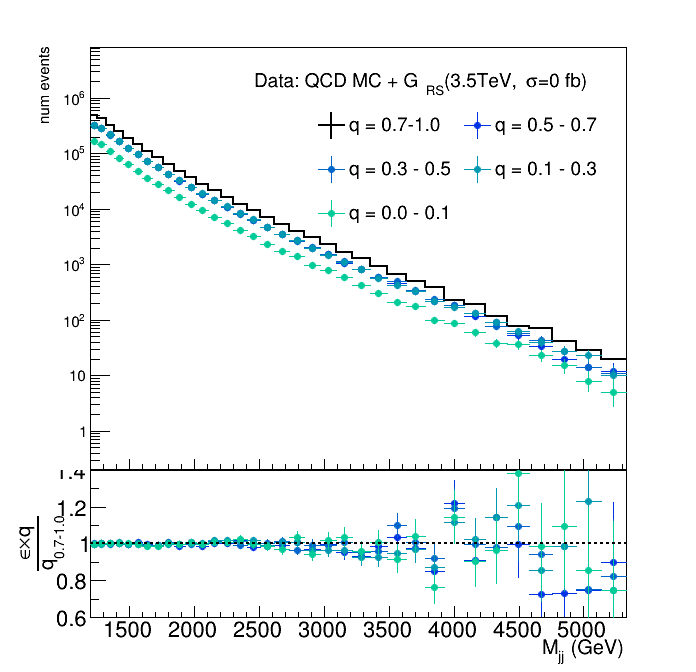

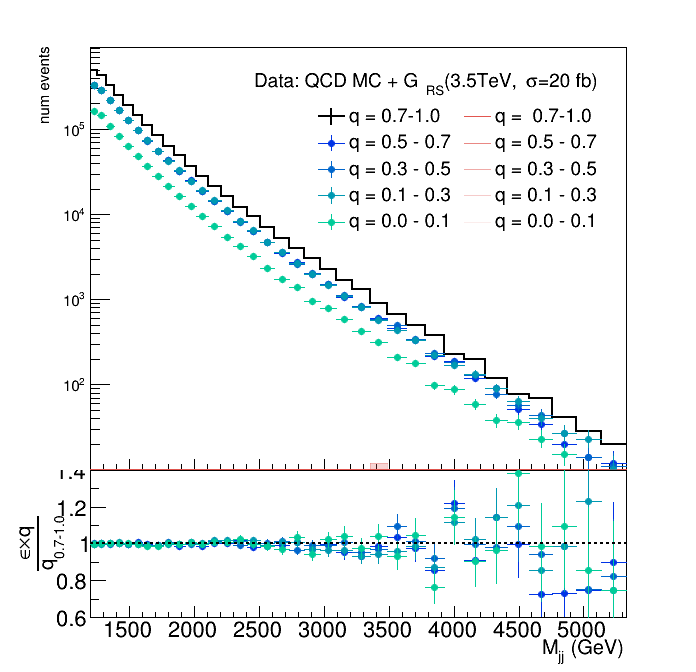

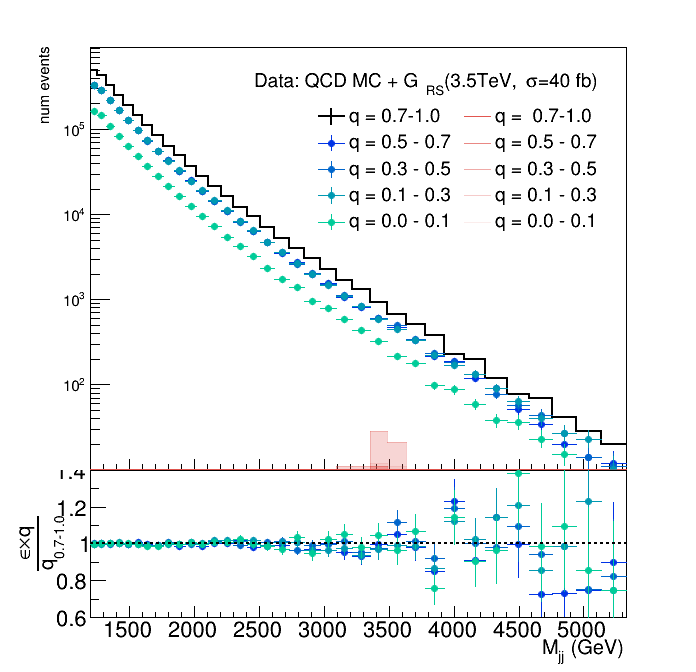

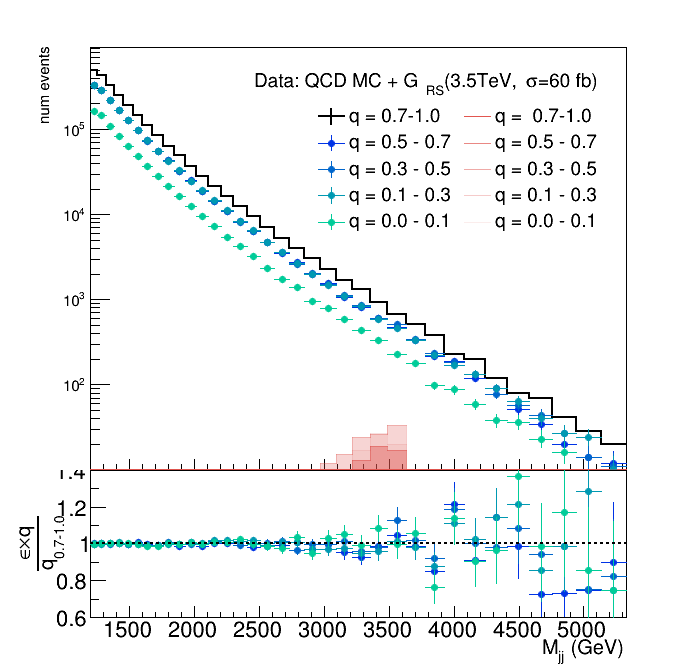

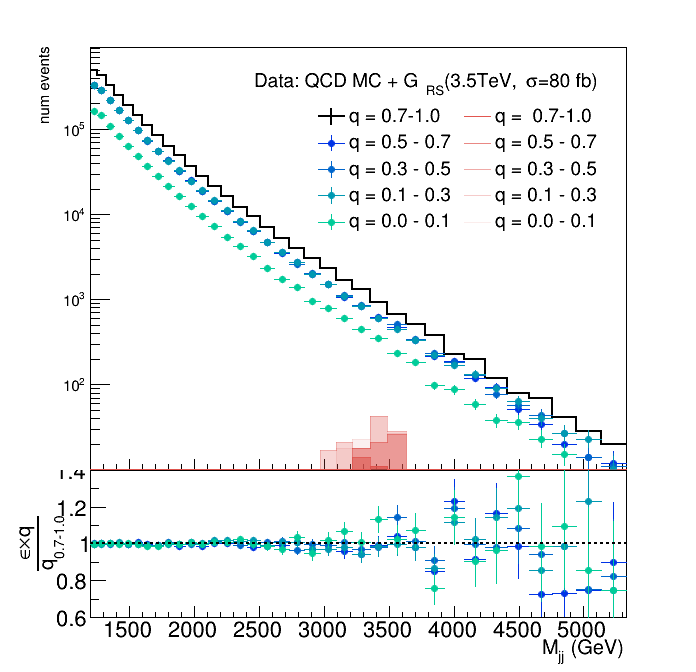

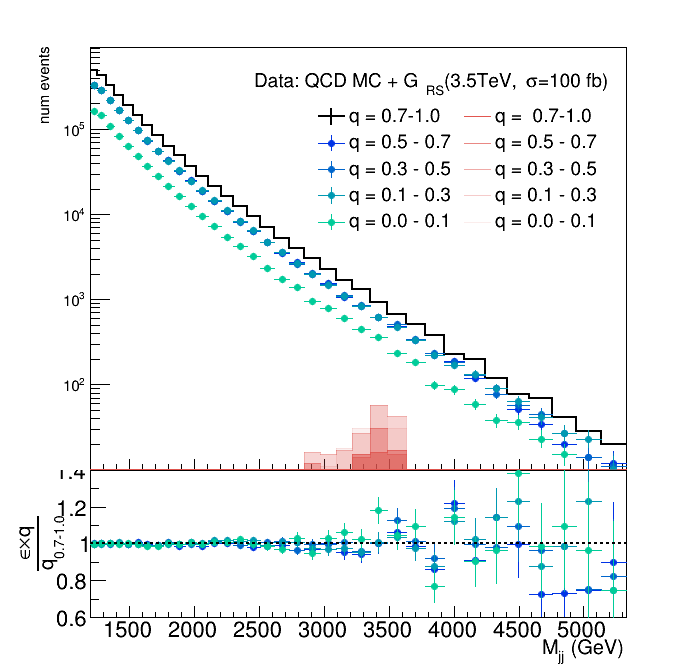

In [17]:
import cmsstyle #mplhep for Python2 cheatsheet

# for each signal injection value
for sig_inj in sig_injs:

    c_out, pad1, pad2 = rpu.create_canvas_pads(pad_props={'LeftMargin': 0.13})
    
    # legend
    leg = rpu.create_object("TLegend", 0.45, 0.5, 0.87, 0.78)
    leg.SetNColumns(2)
    leg_h = rpu.create_object("TLegend", 0.35, 0.8, 0.95, 0.85) # second legend for header because left align not available
    rpu.set_style(leg,props={'TextSize': 0.045})
    rpu.set_style(leg_h,props={'TextSize': 0.045})

    ### plot data histograms

    pad1.cd()

    # draw template bottom quantile data and signal histogram
    ht = histos_data_inj[template_q][sig_inj] 
    ht.Draw('HIST')
    leg.AddEntry(ht, 'q = '+q_str_leg[template_q_idx+1]+'-'+q_str_leg[template_q_idx], 'lep')
    # sig_inj histo at xsec 0 can not be empyt, so filled with 10fb, so have to guard plotting each time :|
    if sig_inj != 0:
        hs = histos_sig_inj[template_q][sig_inj]
        hs.Draw('hist same')
        leg.AddEntry(hs, 'q =  '+q_str_leg[template_q_idx+1]+'-'+q_str_leg[template_q_idx], 'l')


    # draw all other quantile histograms
    for q, q_str_i, q_str_ii in zip(quantiles_inv[template_q_idx+1:], q_str_leg[template_q_idx+2:], q_str_leg[template_q_idx+1:]):
        # data
        h = histos_data_inj[q][sig_inj]
        h.Draw('same')
        leg.AddEntry(h, 'q = {} - {}'.format(q_str_i,q_str_ii), 'lep')
        # signal
        if sig_inj != 0:
            hs = histos_sig_inj[q][sig_inj]
            hs.Draw('hist same')
            leg.AddEntry(hs, 'q = {} - {}'.format(q_str_i,q_str_ii), 'l')

    leg_h.SetHeader(r'Data: QCD MC + G_{RS}(%.1fTeV, #sigma=%i fb)'%(mX,sig_inj*10))
    leg.Draw()
    leg_h.Draw()

    # create ratio histograms
    hr = []
    for q, c in zip(quantiles_inv[template_q_idx+1:], cmap_qcd):
        h = histos_data_inj[q][sig_inj]
        props={"LineColor": rt.TColor.GetColor(c), "MarkerColor": rt.TColor.GetColor(c), "Title": '', "LineWidth": 1, "MarkerStyle": marker_sty}
        r = rpu.create_ratio_hist(h,histos_data_inj[template_q][sig_inj],props=props)
        hr.append(r)
    rpu.set_style(hr[0], props={ "XTitle": 'M_{jj} [GeV]', "YTitle": "ratio SIG / BG"})

    pad2.cd()
    hr[0].Draw('pe')
    props={'YTitle':'#frac{#epsilon#timesq}{q_{'+q_str_leg[template_q_idx+1]+'-'+q_str_leg[template_q_idx]+'}}', 'XTitle':'M_{jj} (GeV)', 'Maximum':1.4, 'Minimum':0.6, 'TitleOffset':0.2}
    rpu.set_style(hr[0],props=props)
    rpu.set_style(hr[0].GetYaxis(),props={'TitleSize':0.11, 'LabelSize':0.12, 'Ndivisions':304, 'TitleOffset':0.4 })
    rpu.set_style(hr[0].GetXaxis(),props={'TitleSize':0.11, 'LabelSize':0.12, 'Ndivisions':304, 'TitleOffset':0.95, 'Ndivisions':909, 'TickSize':0.07 })
    hr[0].GetYaxis().CenterTitle()

    for r in hr[1:]:
        r.Draw('pe same')

    eff_line = rpu.create_ratio_line(hr[0])
    eff_line.Draw('same')

    c_out.Draw()
    c_out.SaveAs('fig/mjj_ratio_inj_sig_xsec_{}_qr_run{}.pdf'.format(sig_inj*10, qr_run_n))

In [18]:
for inj in sig_injs:
    
    sum_sig_inj = sum(histos_sig_inj[q][inj].Integral() for q in quantiles_inv[template_q_idx:])
    sum_data = sum(histos_data_inj[q][inj].Integral() for q in quantiles_inv[template_q_idx:])

    for q in quantiles_inv[template_q_idx:]:
        print('sig inj {}, q {}: {} signal events'.format(inj, q, histos_sig_inj[q][inj].Integral()))

    print('total injected sig events for xsec {}: {} ({:.4f}% of {} data events)'.format(inj*10, sum_sig_inj, (sum_sig_inj/sum_data)*100, sum_data))


sig inj 0, q 1.0: 3.0 signal events
sig inj 0, q 0.7: 8.0 signal events
sig inj 0, q 0.5: 7.0 signal events
sig inj 0, q 0.3: 22.0 signal events
sig inj 0, q 0.1: 20.0 signal events
total injected sig events for xsec 0: 60.0 (0.0008% of 7671637.0 data events)
sig inj 2, q 1.0: 12.0 signal events
sig inj 2, q 0.7: 16.0 signal events
sig inj 2, q 0.5: 22.0 signal events
sig inj 2, q 0.3: 45.0 signal events
sig inj 2, q 0.1: 41.0 signal events
total injected sig events for xsec 20: 136.0 (0.0018% of 7671773.0 data events)
sig inj 4, q 1.0: 31.0 signal events
sig inj 4, q 0.7: 37.0 signal events
sig inj 4, q 0.5: 43.0 signal events
sig inj 4, q 0.3: 93.0 signal events
sig inj 4, q 0.1: 64.0 signal events
total injected sig events for xsec 40: 268.0 (0.0035% of 7671905.0 data events)
sig inj 6, q 1.0: 67.0 signal events
sig inj 6, q 0.7: 43.0 signal events
sig inj 6, q 0.5: 83.0 signal events
sig inj 6, q 0.3: 142.0 signal events
sig inj 6, q 0.1: 108.0 signal events
total injected sig even

## write out histogram files

In [19]:
quantiles_inv

[1.0, 0.7, 0.5, 0.3, 0.1]

In [20]:
# Make one file for shortcut-data

sig_injs = [0,2,4,6,8,10]

outfile = rt.TFile("histograms_injSig_{}.root".format(tag), 'RECREATE' )

for si in sig_injs:
    xs = 10*si    
    for q in quantiles_inv[template_q_idx:]:
        quantile = int(q*100)
        # treat special case when bottom q is bounded on the left: in gof name is hardcoded to q100, so change the name
        if template_q_idx == 1 and q == 0.9: quantile = 100
        print("For xsec {}, q {}".format(xs,quantile))
        histos_data_inj[q][si].Write('data_acc_{}fb_q{}p'.format(xs,quantile))
        histos_sig_inj[q][si].Write('signal_acc_{}fb_q{}p'.format(xs,quantile))

outfile.Close() 

For xsec 0, q 100
For xsec 0, q 70
For xsec 0, q 50
For xsec 0, q 30
For xsec 0, q 10
For xsec 20, q 100
For xsec 20, q 70
For xsec 20, q 50
For xsec 20, q 30
For xsec 20, q 10
For xsec 40, q 100
For xsec 40, q 70
For xsec 40, q 50
For xsec 40, q 30
For xsec 40, q 10
For xsec 60, q 100
For xsec 60, q 70
For xsec 60, q 50
For xsec 60, q 30
For xsec 60, q 10
For xsec 80, q 100
For xsec 80, q 70
For xsec 80, q 50
For xsec 80, q 30
For xsec 80, q 10
For xsec 100, q 100
For xsec 100, q 70
For xsec 100, q 50
For xsec 100, q 30
For xsec 100, q 10
